In a previous post, we gave a numerical demonstration of the *Weyl asymptotic law*, which relates the eigenvalues of the Laplace operator on a domain to its area and perimeter.
If this domain were a drumhead, the eigenvalues are essentially its resonant frequencies.
Weyl's law tells you that you can hear the area and perimeter of a drumhead if only you listen carefully.
In 1966, Mark Kac posed the tantalizing [question](https://www.math.ucdavis.edu/~hunter/m207b/kac.pdf) of whether you could hear not just the area and perimeter, but the entire shape of a drum.
Knowing all the eigenvalues of a domain, can you reconstruct the whole shape?
In what must have been a pretty brutal wet blanket moment, John Milnor [showed](https://www.pnas.org/content/51/4/542) that there are two distinct 16-dimensional manifolds with the same spectrum, so the answer to Kac's question is no in general.
Now I've never played a 16-dimensional drum, but in 1992 a [counterexample](https://www.ams.org/journals/bull/1992-27-01/S0273-0979-1992-00289-6/) was found in the plane.
Here we'll study this problem numerically.

### Geometry

The two shapes we'll use were devised by Gordon, Webb, and Wolpert.
I got the coordinates for the polygon vertices by looking at [this figure](https://en.wikipedia.org/wiki/Hearing_the_shape_of_a_drum#/media/File:Isospectral_drums.svg) from the wikipedia page on hearing the shape of a drum.

In [1]:
import numpy as np
drum1 = np.array([[1, 3],
                  [0, 2],
                  [1, 1],
                  [2, 1],
                  [2, 0],
                  [3, 1],
                  [3, 2],
                  [1, 2]])

drum2 = np.array([[0, 3],
                  [0, 2],
                  [2, 0],
                  [2, 1],
                  [3, 1],
                  [2, 2],
                  [1, 2],
                  [1, 3]])

To solve PDEs on these shapes, we'll first generate outlines using the package [pygmsh]() and save it to a .geo file.

In [2]:
import pygmsh
def make_geo(vertices, name, δx = 0.25):
    geometry = pygmsh.built_in.Geometry()
    N = len(vertices)

    points = [geometry.add_point([x[0], x[1], 0], lcar=δx) for x in vertices]
    lines = [geometry.add_line(points[n], points[(n + 1) % N]) for n in range(N)]
    line_loop = geometry.add_line_loop(lines)
    plane_surface = geometry.add_plane_surface(line_loop)

    for line in lines:
        geometry.add_physical(line)
    geometry.add_physical(plane_surface)

    with open(name, 'w') as geo_file:
        geo_file.write(geometry.get_code())

In [3]:
make_geo(drum1, 'drum1.geo')
make_geo(drum2, 'drum2.geo')

Then we'll use the mesh generator [gmsh](https://www.gmsh.info) to triangulate the interiors of each polygon and save the resulting mesh to a .msh file.

In [4]:
!gmsh -2 -format msh2 -v 0 drum1.geo
!gmsh -2 -format msh2 -v 0 drum2.geo

Finally we'll read in the meshes using Firedrake and refine them.

In [5]:
import firedrake
coarse_mesh1 = firedrake.Mesh('drum1.msh')
mesh_hierarchy1 = firedrake.MeshHierarchy(coarse_mesh1, 4)
mesh1 = mesh_hierarchy1[-1]

coarse_mesh2 = firedrake.Mesh('drum2.msh')
mesh_hierarchy2 = firedrake.MeshHierarchy(coarse_mesh2, 4)
mesh2 = mesh_hierarchy2[-1]

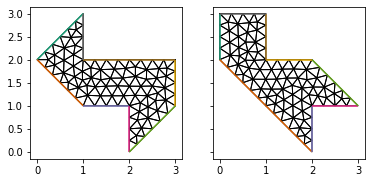

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
for ax in axes:
    ax.set_aspect('equal')
    
firedrake.triplot(coarse_mesh1, axes=axes[0])
firedrake.triplot(coarse_mesh2, axes=axes[1]);

### Solving the eigenproblem

To solve the eigenproblem, we'll use routines from package [SLEPc](http://slepc.upv.es/) just like we've done before for Weyl's law and Yau's conjecture.
Since Firedrake is built on top of PETSc, any assembled linear operator has a PETSc matrix object living somewhere in the murky depths.
Setting up the eigenproblem is just a matter of pulling out the underlying matrix objects and passing them to SLEPc.

In [7]:
from firedrake import inner, grad, dx
from petsc4py import PETSc
from slepc4py import SLEPc

def get_eigenvalues(mesh, num_eigenvalues=200):
    Q = firedrake.FunctionSpace(mesh, 'CG', 1)
    ϕ = firedrake.TestFunction(Q)
    ψ = firedrake.TrialFunction(Q)
    a = inner(grad(ϕ), grad(ψ)) * dx
    m = ϕ * ψ * dx

    bc = firedrake.DirichletBC(Q, firedrake.Constant(0), 'on_boundary')
    A = firedrake.assemble(a, bcs=bc).M.handle
    M = firedrake.assemble(m).M.handle

    opts = PETSc.Options()
    opts.setValue('eps_gen_hermitian', None)
    opts.setValue('eps_target_real', None)
    opts.setValue('eps_smallest_real', None)
    opts.setValue('st_type', 'sinvert')
    opts.setValue('st_ksp_type', 'cg')
    opts.setValue('st_pc-type', 'jacobi')
    opts.setValue('eps_tol', 1e-8)
    
    eigensolver = SLEPc.EPS().create(comm=firedrake.COMM_WORLD)
    eigensolver.setDimensions(num_eigenvalues)
    eigensolver.setOperators(A, M)
    eigensolver.setFromOptions()
    
    eigensolver.solve()
    
    num_converged = eigensolver.getConverged()
    λs = np.array([eigensolver.getEigenvalue(k) for k in range(num_converged)]).real
    return λs

As we expect, the eigenvaue distribution of the two domains is practically the same in the eyeball norm.

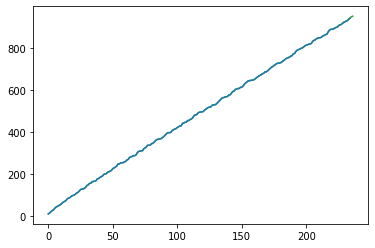

In [8]:
Λ1 = get_eigenvalues(mesh1)
Λ2 = get_eigenvalues(mesh2)

fig, axes = plt.subplots()
axes.plot(Λ1, color='tab:green')
axes.plot(Λ2, color='tab:blue');

To be more precise, the relative difference in the first 200 eigenvalues is below a 0.1%.

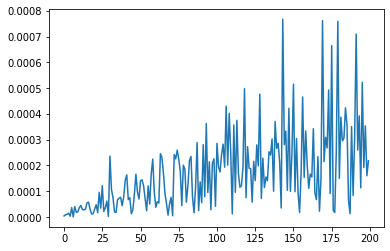

In [9]:
fig, axes = plt.subplots()
axes.plot(list(range(200)), np.abs((Λ1[:200] - Λ2[:200]) / Λ2[:200]));

### Discussion

Steve Zelditch has a wonderful [review](https://arxiv.org/pdf/1504.02000.pdf) of this topic on arXiv.
As we've shown here experimentally, there are distinct isospectral planar domains, but the domains we used aren't convex.
Zelditch proved that the spectrum uniquely characterizes the domain if it's convex and has an analytic boundary.

This type of problem has ramifications beyond just diverting mathematicians.
For example, the same underlying mathematics shows up in eigenvalue problems for the Schroedinger equation.
Knowing the interatomic potential, it's possible to calculate the quantum-mechanical energy levels.
But if it's possible to infer things about potentials from energy levels -- essentially the Kac conjecture but for quantum mechanics -- then this could be useful in experimental physics as well.